<a href="https://colab.research.google.com/github/jai2shan/TSAI_END2/blob/main/Session%203/Session_3_Pytorch%2097%20Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 3  - Assignment


---
Digit Recognizer     
---
Train Accuracy : 98.84%     
Test Accuracy  : 99.07%  


---
Sum Calculator Model    
---
Train Accuracy : 94.47%     
Test Accuracy  : 97.26%     
 

---

## Data Downloading


Downloading data to colab environment using Pytorch




In [ ]:
from torchvision import datasets
datasets.MNIST('data', download=True)

## Importing the necessary modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

## Custom Data Loader

1. Loaded the downloaded data from the colab environment using torch.load method
2. In the "__getitem__" method,
          1) Loaded the data
          2) Created randomm integer
          3) Made a tuple with the expected target variables and input variables

In [9]:
class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

## Load the data and check of GPU is available for training the model

In [10]:
torch.manual_seed(1)
batch_size = 1024
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

# Network Architecture
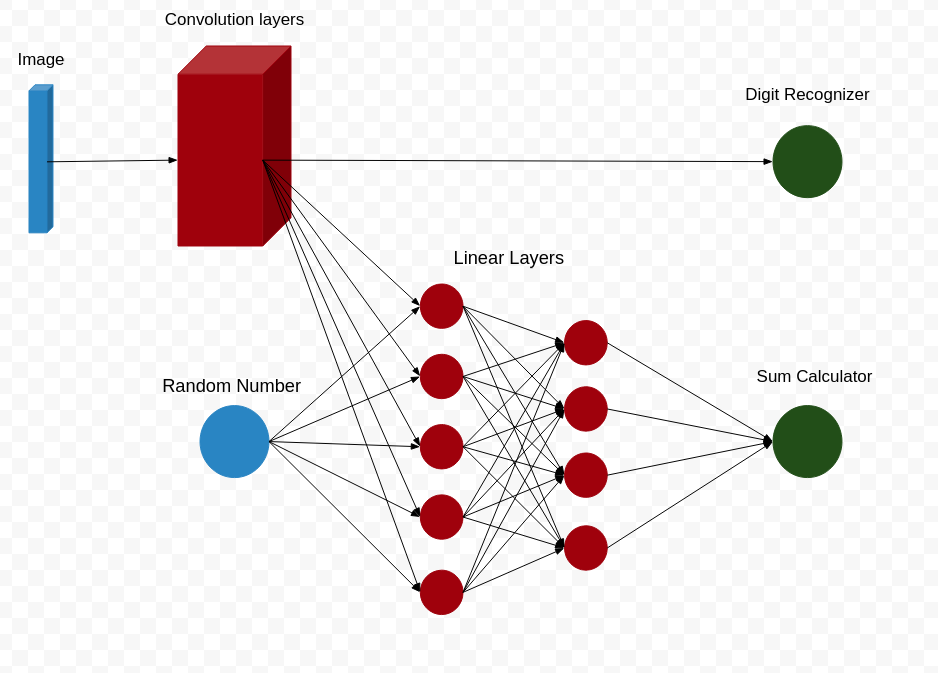

In [30]:

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,30)
        self.ln2 = nn.Linear(30,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        img = img.view(-1, 10)

        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)
        rnum = self.relu(rnum)
        rnum = self.ln2(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

## Enable cuda for calculation
1. Check if GPU is available for computation
2. if available move the model to GPU

In [31]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


## Train and Test Functions

Model will be trained by following below steps:
1. Move the below variables to GPU       
    a) x1 - Image      
    b) x2 - Random Number     
    c) y1 - image output     
    d) y2 - Sum of digit in the image and random number     
2. Calculate loss using the Negative loglikelihood function for both digit recognizing and sum calculation
3. Calculate total loss by adding both the values. To improve model accuracy, loss2(Sum calculation network loss) is multiplied by 2 in order to increase its weightage in loss so that the overall loss is magnified for every one unit of loss in Sum calculation network 
4. Plot function will help us visualize improve of accuracy with various epochs





In [36]:
def train(model, device, train_loader, optimizer, epoch,loss1_,loss2_):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()


    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))



def plot_performance(train_acc, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))

  axs[0, 0].plot(train_acc['Image'])
  axs[0, 0].set_title("Training - Image")
  axs[0, 1].plot(train_acc['RandomNumber'])
  axs[0, 1].set_title("Training - Random Number Model")
  axs[1, 0].plot(test_acc['Image'])
  axs[1, 0].set_title("Test - Image")
  axs[1, 1].plot(test_acc['RandomNumber'])
  axs[1, 1].set_title("Test - Random Number Model")

## Defining Optimiser and Training the model

  0%|          | 0/59 [00:00<?, ?it/s]

EPOCH: 0


Loss=6.588630199432373 Batch_id=58 Accuracy_digit=43.09 Accuracy_Rnum=9.55: 100%|██████████| 59/59 [00:02<00:00, 25.81it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=53.36 Accuracy_Rnum=13.99
EPOCH: 1


Loss=4.791028022766113 Batch_id=58 Accuracy_digit=75.21 Accuracy_Rnum=19.59: 100%|██████████| 59/59 [00:02<00:00, 25.38it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=86.24 Accuracy_Rnum=27.95
EPOCH: 2


Loss=3.5850911140441895 Batch_id=58 Accuracy_digit=91.25 Accuracy_Rnum=33.00: 100%|██████████| 59/59 [00:02<00:00, 25.96it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=94.51 Accuracy_Rnum=39.83
EPOCH: 3


Loss=2.941157102584839 Batch_id=58 Accuracy_digit=94.36 Accuracy_Rnum=43.88: 100%|██████████| 59/59 [00:02<00:00, 26.03it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=95.77 Accuracy_Rnum=46.88
EPOCH: 4


Loss=2.6859681606292725 Batch_id=58 Accuracy_digit=95.64 Accuracy_Rnum=51.76: 100%|██████████| 59/59 [00:02<00:00, 25.67it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.24 Accuracy_Rnum=56.92
EPOCH: 5


Loss=2.4623472690582275 Batch_id=58 Accuracy_digit=96.36 Accuracy_Rnum=59.49: 100%|██████████| 59/59 [00:02<00:00, 26.03it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.94 Accuracy_Rnum=64.54
EPOCH: 6


Loss=2.205270290374756 Batch_id=58 Accuracy_digit=96.88 Accuracy_Rnum=63.24: 100%|██████████| 59/59 [00:02<00:00, 25.82it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=96.45 Accuracy_Rnum=60.58
EPOCH: 7


Loss=1.9753559827804565 Batch_id=58 Accuracy_digit=97.12 Accuracy_Rnum=67.73: 100%|██████████| 59/59 [00:02<00:00, 25.71it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.18 Accuracy_Rnum=70.41
EPOCH: 8


Loss=2.036909818649292 Batch_id=58 Accuracy_digit=97.32 Accuracy_Rnum=70.91: 100%|██████████| 59/59 [00:02<00:00, 25.64it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.77 Accuracy_Rnum=68.48
EPOCH: 9


Loss=1.63469398021698 Batch_id=58 Accuracy_digit=97.49 Accuracy_Rnum=72.28: 100%|██████████| 59/59 [00:02<00:00, 25.75it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.5 Accuracy_Rnum=78.48
EPOCH: 10


Loss=1.6003116369247437 Batch_id=58 Accuracy_digit=97.65 Accuracy_Rnum=75.65: 100%|██████████| 59/59 [00:02<00:00, 25.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.32 Accuracy_Rnum=79.21
EPOCH: 11


Loss=1.728318214416504 Batch_id=58 Accuracy_digit=97.81 Accuracy_Rnum=76.23: 100%|██████████| 59/59 [00:02<00:00, 26.11it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.65 Accuracy_Rnum=80.43
EPOCH: 12


Loss=1.4537787437438965 Batch_id=58 Accuracy_digit=97.86 Accuracy_Rnum=77.09: 100%|██████████| 59/59 [00:02<00:00, 25.35it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.49 Accuracy_Rnum=81.77
EPOCH: 13


Loss=1.562452793121338 Batch_id=58 Accuracy_digit=97.93 Accuracy_Rnum=78.42: 100%|██████████| 59/59 [00:02<00:00, 25.75it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.66 Accuracy_Rnum=81.07
EPOCH: 14


Loss=1.4832197427749634 Batch_id=58 Accuracy_digit=98.00 Accuracy_Rnum=81.42: 100%|██████████| 59/59 [00:02<00:00, 25.63it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.5 Accuracy_Rnum=84.32
EPOCH: 15


Loss=1.343523383140564 Batch_id=58 Accuracy_digit=98.11 Accuracy_Rnum=81.19: 100%|██████████| 59/59 [00:02<00:00, 25.66it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.75 Accuracy_Rnum=85.14
EPOCH: 16


Loss=1.4183871746063232 Batch_id=58 Accuracy_digit=98.14 Accuracy_Rnum=83.68: 100%|██████████| 59/59 [00:02<00:00, 25.33it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.75 Accuracy_Rnum=87.19
EPOCH: 17


Loss=1.2408790588378906 Batch_id=58 Accuracy_digit=98.20 Accuracy_Rnum=85.19: 100%|██████████| 59/59 [00:02<00:00, 25.87it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.76 Accuracy_Rnum=87.95
EPOCH: 18


Loss=1.2410627603530884 Batch_id=58 Accuracy_digit=98.26 Accuracy_Rnum=83.75: 100%|██████████| 59/59 [00:02<00:00, 25.77it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=87.19
EPOCH: 19


Loss=1.1964044570922852 Batch_id=58 Accuracy_digit=98.24 Accuracy_Rnum=84.97: 100%|██████████| 59/59 [00:02<00:00, 25.41it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.81 Accuracy_Rnum=85.98
EPOCH: 20


Loss=1.247045874595642 Batch_id=58 Accuracy_digit=98.29 Accuracy_Rnum=86.28: 100%|██████████| 59/59 [00:02<00:00, 25.47it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.78 Accuracy_Rnum=92.31
EPOCH: 21


Loss=1.0079885721206665 Batch_id=58 Accuracy_digit=98.38 Accuracy_Rnum=87.53: 100%|██████████| 59/59 [00:02<00:00, 25.60it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.58 Accuracy_Rnum=85.82
EPOCH: 22


Loss=1.1339330673217773 Batch_id=58 Accuracy_digit=98.38 Accuracy_Rnum=87.77: 100%|██████████| 59/59 [00:02<00:00, 25.82it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=93.64
EPOCH: 23


Loss=1.075819730758667 Batch_id=58 Accuracy_digit=98.44 Accuracy_Rnum=88.11: 100%|██████████| 59/59 [00:02<00:00, 26.28it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=87.81
EPOCH: 24


Loss=0.8128015398979187 Batch_id=58 Accuracy_digit=98.41 Accuracy_Rnum=88.42: 100%|██████████| 59/59 [00:02<00:00, 25.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.97 Accuracy_Rnum=92.19
EPOCH: 25


Loss=0.9863678812980652 Batch_id=58 Accuracy_digit=98.43 Accuracy_Rnum=89.03: 100%|██████████| 59/59 [00:02<00:00, 25.39it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=94.34
EPOCH: 26


Loss=0.840358316898346 Batch_id=58 Accuracy_digit=98.47 Accuracy_Rnum=89.41: 100%|██████████| 59/59 [00:02<00:00, 25.90it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=92.94
EPOCH: 27


Loss=0.8363089561462402 Batch_id=58 Accuracy_digit=98.49 Accuracy_Rnum=90.28: 100%|██████████| 59/59 [00:02<00:00, 25.25it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=93.56
EPOCH: 28


Loss=0.9323498606681824 Batch_id=58 Accuracy_digit=98.50 Accuracy_Rnum=89.89: 100%|██████████| 59/59 [00:02<00:00, 25.55it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=95.31
EPOCH: 29


Loss=1.5627361536026 Batch_id=58 Accuracy_digit=98.53 Accuracy_Rnum=91.64: 100%|██████████| 59/59 [00:02<00:00, 25.74it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=94.73
EPOCH: 30


Loss=0.9585432410240173 Batch_id=58 Accuracy_digit=98.53 Accuracy_Rnum=90.87: 100%|██████████| 59/59 [00:02<00:00, 25.39it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.87 Accuracy_Rnum=94.32
EPOCH: 31


Loss=0.7154804468154907 Batch_id=58 Accuracy_digit=98.65 Accuracy_Rnum=92.05: 100%|██████████| 59/59 [00:02<00:00, 25.34it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.97 Accuracy_Rnum=93.45
EPOCH: 32


Loss=0.8275046348571777 Batch_id=58 Accuracy_digit=98.65 Accuracy_Rnum=92.38: 100%|██████████| 59/59 [00:02<00:00, 25.04it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.94 Accuracy_Rnum=95.38
EPOCH: 33


Loss=0.7017554640769958 Batch_id=58 Accuracy_digit=98.60 Accuracy_Rnum=92.49: 100%|██████████| 59/59 [00:02<00:00, 25.96it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=95.04
EPOCH: 34


Loss=0.8875284194946289 Batch_id=58 Accuracy_digit=98.67 Accuracy_Rnum=93.03: 100%|██████████| 59/59 [00:02<00:00, 25.26it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.14 Accuracy_Rnum=95.07
EPOCH: 35


Loss=0.7935984134674072 Batch_id=58 Accuracy_digit=98.61 Accuracy_Rnum=92.34: 100%|██████████| 59/59 [00:02<00:00, 25.20it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.02 Accuracy_Rnum=96.04
EPOCH: 36


Loss=0.6649078130722046 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=93.34: 100%|██████████| 59/59 [00:02<00:00, 25.39it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=96.42
EPOCH: 37


Loss=0.8209342956542969 Batch_id=58 Accuracy_digit=98.62 Accuracy_Rnum=93.69: 100%|██████████| 59/59 [00:02<00:00, 25.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=96.1
EPOCH: 38


Loss=0.5072059631347656 Batch_id=58 Accuracy_digit=98.65 Accuracy_Rnum=93.73: 100%|██████████| 59/59 [00:02<00:00, 25.37it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.94 Accuracy_Rnum=96.7
EPOCH: 39


Loss=0.6518025994300842 Batch_id=58 Accuracy_digit=98.70 Accuracy_Rnum=94.08: 100%|██████████| 59/59 [00:02<00:00, 25.85it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=96.54
EPOCH: 40


Loss=0.8289991617202759 Batch_id=58 Accuracy_digit=98.74 Accuracy_Rnum=93.78: 100%|██████████| 59/59 [00:02<00:00, 25.57it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.12 Accuracy_Rnum=96.76
EPOCH: 41


Loss=0.5272982716560364 Batch_id=58 Accuracy_digit=98.73 Accuracy_Rnum=94.39: 100%|██████████| 59/59 [00:02<00:00, 25.10it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=97.23
EPOCH: 42


Loss=0.5012201070785522 Batch_id=58 Accuracy_digit=98.79 Accuracy_Rnum=94.24: 100%|██████████| 59/59 [00:02<00:00, 25.59it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.26 Accuracy_Rnum=96.82
EPOCH: 43


Loss=0.6259458065032959 Batch_id=58 Accuracy_digit=98.85 Accuracy_Rnum=94.41: 100%|██████████| 59/59 [00:02<00:00, 25.65it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.07 Accuracy_Rnum=96.87
EPOCH: 44


Loss=0.4567472040653229 Batch_id=58 Accuracy_digit=98.78 Accuracy_Rnum=94.51: 100%|██████████| 59/59 [00:02<00:00, 25.84it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=96.9
EPOCH: 45


Loss=0.7198973298072815 Batch_id=58 Accuracy_digit=98.78 Accuracy_Rnum=94.08: 100%|██████████| 59/59 [00:02<00:00, 25.15it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.26 Accuracy_Rnum=96.84
EPOCH: 46


Loss=0.8698937296867371 Batch_id=58 Accuracy_digit=98.85 Accuracy_Rnum=94.41: 100%|██████████| 59/59 [00:02<00:00, 25.13it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.18 Accuracy_Rnum=96.26
EPOCH: 47


Loss=0.46058592200279236 Batch_id=58 Accuracy_digit=98.82 Accuracy_Rnum=94.92: 100%|██████████| 59/59 [00:02<00:00, 25.80it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.03 Accuracy_Rnum=97.22
EPOCH: 48


Loss=0.7295564413070679 Batch_id=58 Accuracy_digit=98.86 Accuracy_Rnum=95.04: 100%|██████████| 59/59 [00:02<00:00, 25.12it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=96.98
EPOCH: 49


Loss=0.41632115840911865 Batch_id=58 Accuracy_digit=98.84 Accuracy_Rnum=94.47: 100%|██████████| 59/59 [00:02<00:00, 25.26it/s]


Test set: Accuracy_digit=99.07 Accuracy_Rnum=97.26


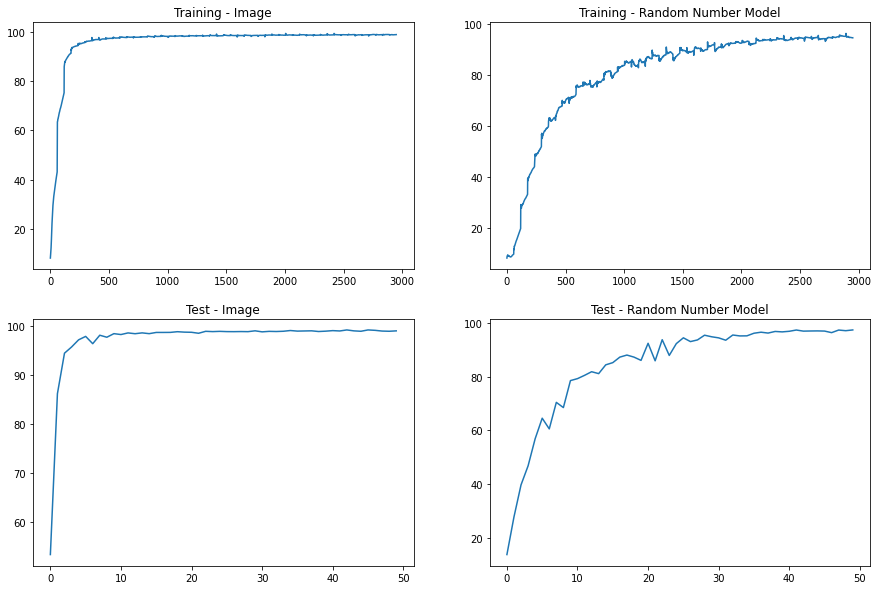

In [38]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,loss1_,loss2_)
    test(model, device, test_loader)

plot_performance(train_acc, test_acc)